In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for content based filtering
from sklearn.metrics.pairwise import linear_kernel

#for collaborative filtering
import os
import math
import random

from surprise import accuracy, Reader, Dataset, dump
from surprise import NormalPredictor, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV

In [3]:
pd.options.display.float_format = '{:.2f}'.format
Ratings = pd.read_csv('Ratings.csv')
Books = pd.read_csv('DataGabungan.csv')

In [ ]:
Ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [4]:
#updating column names in ratings dataset
Ratings.rename(columns = {"User-ID":"user_id", "Book-Rating": "rating"}, inplace=True)

Ratings = Ratings[Ratings['rating'] != 0]

counters = Ratings.groupby(['user_id', 'ISBN']).size().reset_index(name='rating_count')

# Filter users who have rated more than 30 books and books that have more than 40 ratings
user_filter = counters.groupby('user_id').size() >= 30
book_filter = counters.groupby('ISBN').size() >= 40

# Apply the filters to the original dataset
Ratings = Ratings[Ratings['user_id'].isin(user_filter[user_filter].index) & Ratings['ISBN'].isin(book_filter[book_filter].index)]

Books.drop(['Unnamed: 0', 'user_id', 'rating'], axis=1, inplace=True)

In [6]:
Ratings

,user_id,ISBN,rating
1456,277427,002542730X,10
1474,277427,0061009059,9
1522,277427,0316776963,8
1543,277427,0345413903,10
1578,277427,0385424736,9
...,...,...,...
1149530,276680,0385504209,8
1149551,276680,0440221595,8
1149564,276680,0452283205,7
1149581,276680,0679781587,9


In [5]:
Books

,ISBN,title,author,publisher,image,year,average_rating,count_ratings
0,0060283130,The Reptile Room (A Series of Unfortunate Even...,Lemony Snicket,HarperCollins,http://images.amazon.com/images/P/0060283130.0...,1999,8.00,49
1,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,Regan Books,http://images.amazon.com/images/P/0060392452.0...,2002,8.34,3364
2,0060502258,The Divine Secrets of the Ya-Ya Sisterhood: A ...,Rebecca Wells,HarperTorch,http://images.amazon.com/images/P/0060502258.0...,2002,7.81,3364
3,0060809833,Brave New World,Aldous Huxley,Harpercollins,http://images.amazon.com/images/P/0060809833.0...,1989,9.10,100
4,0060830956,Brave New World,Aldous Huxley,HarperCollins Publishers,http://images.amazon.com/images/P/0060830956.0...,1984,8.75,64
...,...,...,...,...,...,...,...,...
358,1573226122,Lord of the Flies,William Golding,Riverhead Books,http://images.amazon.com/images/P/1573226122.0...,1997,7.88,64
359,1573228214,High Fidelity,Nick Hornby,Riverhead Books,http://images.amazon.com/images/P/1573228214.0...,2000,7.44,256
360,1573229326,How to Be Good,Nick Hornby,Riverhead Books,http://images.amazon.com/images/P/1573229326.0...,2002,7.03,1089
361,185326041X,The Great Gatsby,F. Scott Fitzgerald,Lb May &amp; Assoc Inc,http://images.amazon.com/images/P/185326041X.0...,1999,8.17,36


**Collaborative Filtering**



In [7]:
#to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

#Load the full dataset
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(Ratings, reader)

#shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

#split data into train and test data with the ratio 70:30
threshold = int(0.7 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(Books['ISBN'])
    book_read_list = list(Ratings['ISBN'][Ratings['user_id'] == user_id])
    return books_list, book_read_list

In [ ]:
# # Menghitung jumlah rating per user
# user_rating_counts = Ratings.groupby('user_id').size()

# # Memfilter pengguna dengan lebih dari 30 rating
# # filtered_users = user_rating_counts[user_rating_counts >= 30]

# # Mengurutkan hasil berdasarkan count_rating secara descending
# filtered_users_sorted = user_rating_counts.sort_values(ascending=False)

# # Menampilkan hasil dalam DataFrame dengan format yang diinginkan
# df_filtered_users = pd.DataFrame({'user_id': filtered_users_sorted.index, 'count_ratings': filtered_users_sorted.values})
# df_filtered_users

a. Normal Predictor

In [ ]:
%%time

# prepare train data
data.raw_ratings = train_ratings

#select algorithm
npred = NormalPredictor()

# cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=1)

#retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)
print('\n')

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)
print('Train MAE:')
train_mae = accuracy.mae(np_train_pred)
print('\n')

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)
print('Test MAE:')
test_mae = accuracy.mae(np_test_pred)

data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.3642  2.3380  2.2732  2.2996  2.3069  2.3164  0.0316  
Fit time          0.01    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.02    0.01    0.01    0.01    0.01    0.00    


Train RMSE:
RMSE: 2.3383
Train MAE:
MAE:  1.8497


Test RMSE:
RMSE: 2.3316
Test MAE:
MAE:  1.8414
CPU times: user 681 ms, sys: 9.88 ms, total: 690 ms
Wall time: 698 ms


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_np', np_test_pred, npred)
dump

<module 'surprise.dump' from '/usr/local/lib/python3.10/dist-packages/surprise/dump.py'>

In [ ]:
get_recommendation_npred(11676, 5)

,ISBN,title,author,average_rating,count_ratings
4,0060830956,Brave New World,Aldous Huxley,8.75,64
8,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,8.08,3600
34,0142001740,The Secret Life of Bees,Sue Monk Kidd,8.81,9409
35,015100692X,The Crimson Petal and the White,Michel Faber,7.58,576
55,0312983271,Full House (Janet Evanovich's Full Series),Janet Evanovich,7.72,1600


K-Nearest Neighbour

In [ ]:
%%time
# change data to trainset
data.raw_ratings = train_ratings

# select algorithm
sim_options = {"name": "cosine",
              "user_based": True}
knn = KNNBasic(sim_options=sim_options)

# cross validation for train data
knn_result = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True, n_jobs = 1)

# retrain whole train test
trainset = data.build_full_trainset()
knn.fit(trainset)

# Compute RMSE on trainset (without fold)
knn_train_pred = knn.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(knn_train_pred)
print('Train MAE:')
train_mae = accuracy.mae(knn_train_pred)
print('\n')

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
knn_test_pred = knn.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(knn_test_pred)
print('Test MAE:')
test_mae = accuracy.mae(knn_test_pred)
print('\n')

data.raw_ratings = all_ratings
knn.fit(data.build_full_trainset())

def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = knn.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9026  1.9146  1.8436  1.8665  1.8940  1.8843  0.0258  
Fit time          0.24    0.19    0.18    0.22    0.10    0.19    0.05    
Test time         0.10    0.11    0.12    0.10    0.10    0.10    0.01    
Computing the cosine similarity matrix...
Done computing similarity matrix.
Train RMSE:
RMSE: 1.6055
Train MAE:
MAE:  1.2609


Test RMSE:
RMSE: 1.8271
Test MAE:
MAE:  1.4134


Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: use

In [ ]:
dump.dump('./dump_knn', knn_test_pred, knn)

In [ ]:
def get_recommendation_knn(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = knn.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation_knn(11676, 5)

,ISBN,title,author,average_rating,count_ratings
82,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,9.18,1444
83,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,9.41,1369
173,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,9.20,6561
177,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,9.03,12544
333,076790592X,"Tuesdays with Morrie: An Old Man, a Young Man,...",Mitch Albom,9.11,81


SVD (Singular Value Decomposition)

In [ ]:
%%time
#change data to trainset
data.raw_ratings = train_ratings

#select algorithm
svd = SVD(random_state=0)

#retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# Compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)
print('Train MAE:')
train_mae = accuracy.mae(svd_train_pred)
print('\n')

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)
print('Test MAE:')
train_mae = accuracy.mae(svd_test_pred)
print('\n')

data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svd.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

Train RMSE:
RMSE: 1.0205
Train MAE:
MAE:  0.7905


Test RMSE:
RMSE: 1.5652
Test MAE:
MAE:  1.1933


CPU times: user 1.4 s, sys: 16.3 ms, total: 1.42 s
Wall time: 1.54 s


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_svd', svd_test_pred, svd)
dump

<module 'surprise.dump' from '/usr/local/lib/python3.10/dist-packages/surprise/dump.py'>

In [ ]:
get_recommendation_svd(11676, 5)

,ISBN,title,author,average_rating,count_ratings
52,0312971346,High Five (A Stephanie Plum Novel),Janet Evanovich,8.73,2304
80,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,8.76,3844
81,0345339703,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,9.00,2025
138,0385492081,Into Thin Air : A Personal Account of the Mt. ...,JON KRAKAUER,8.57,1764
184,0440212561,Outlander,DIANA GABALDON,8.38,1521


SVD++


In [ ]:
%%time
#change data to trainset
data.raw_ratings = train_ratings

#select algorithm
svdpp = SVDpp(random_state=0)

#retrain whole train test
trainset = data.build_full_trainset()
svdpp.fit(trainset)

# Compute RMSE on trainset (without fold)
svdpp_train_pred = svdpp.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdpp_train_pred)
print('Train MAE:')
train_mae = accuracy.mae(svdpp_train_pred)
print('\n')


#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdpp_test_pred = svdpp.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdpp_test_pred)
print('Test MAE:')
train_mae = accuracy.mae(svdpp_test_pred)
print('\n')


data.raw_ratings = all_ratings
svdpp.fit(data.build_full_trainset())

def get_recommendation_svdpp(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdpp.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

Train RMSE:
RMSE: 1.0143
Train MAE:
MAE:  0.7803


Test RMSE:
RMSE: 1.5729
Test MAE:
MAE:  1.1891


CPU times: user 3.7 s, sys: 113 ms, total: 3.81 s
Wall time: 3.75 s


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_svdpp', svdpp_test_pred, svdpp)
dump

<module 'surprise.dump' from '/usr/local/lib/python3.10/dist-packages/surprise/dump.py'>

In [ ]:
get_recommendation_svdpp(11676, 5)

,ISBN,title,author,average_rating,count_ratings
34,0142001740,The Secret Life of Bees,Sue Monk Kidd,8.81,9409
54,0312980140,Seven Up (A Stephanie Plum Novel),Janet Evanovich,8.56,2916
69,0316769487,The Catcher in the Rye,J.D. Salinger,7.60,7396
98,0345413369,"The Subtle Knife (His Dark Materials, Book 2)",PHILIP PULLMAN,8.60,225
183,0440211727,A Time to Kill,JOHN GRISHAM,8.05,6724


**Precision, Recall, F1 Score**

In [ ]:
import numpy as np
from collections import defaultdict

# Function to get top K recommendations for each user
def get_top_k_recommendations(predictions, k):
    # Map the predictions to each user.
    top_k_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k_recs[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_k_recs.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k_recs[uid] = user_ratings[:k]

    return top_k_recs

# Function to calculate Precision@K, Recall@K, and F1@K
def precision_recall_f1_at_k(predictions, k, threshold=4.0):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1_scores = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Get the top K items
        user_ratings_top_k = user_ratings[:k]

        # Count relevant items in top K
        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings_top_k)

        # Count relevant items in all items rated by user
        n_relevant_total = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision@K
        precisions[uid] = n_relevant / k

        # Recall@K
        recalls[uid] = n_relevant / n_relevant_total if n_relevant_total != 0 else 0

        # F1@K
        if precisions[uid] + recalls[uid] > 0:
            f1_scores[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
        else:
            f1_scores[uid] = 0

    # Average precision and recall over all users
    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    mean_f1 = np.mean(list(f1_scores.values()))

    return mean_precision, mean_recall, mean_f1

# Example usage with predictions from your model
top_k = 5
knn_top_k_recommendations = get_top_k_recommendations(knn_test_pred, top_k)
knn_mean_precision, knn_mean_recall, knn_mean_f1 = precision_recall_f1_at_k(knn_test_pred, top_k)

print(f'KNN Precision@{top_k}: {knn_mean_precision:.4f}')
print(f'KNN Recall@{top_k}: {knn_mean_recall:.4f}')
print(f'KNN F1@{top_k}: {knn_mean_f1:.4f}')
print('\n')

np_top_k_recommendations = get_top_k_recommendations(np_test_pred, top_k)
np_mean_precision, np_mean_recall, np_mean_f1 = precision_recall_f1_at_k(np_test_pred, top_k)

print(f'Normal Predictor Precision@{top_k}: {np_mean_precision:.4f}')
print(f'Normal Predictor Recall@{top_k}: {np_mean_recall:.4f}')
print(f'Normal Predictor F1@{top_k}: {np_mean_f1:.4f}')
print('\n')

svd_top_k_recommendations = get_top_k_recommendations(svd_test_pred, top_k)
svd_mean_precision, svd_mean_recall, svd_mean_f1 = precision_recall_f1_at_k(svd_test_pred, top_k)

print(f'SVD Precision@{top_k}: {svd_mean_precision:.4f}')
print(f'SVD Recall@{top_k}: {svd_mean_recall:.4f}')
print(f'SVD F1@{top_k}: {svd_mean_f1:.4f}')
print('\n')

svdpp_top_k_recommendations = get_top_k_recommendations(svdpp_test_pred, top_k)
svdpp_mean_precision, svdpp_mean_recall, svdpp_mean_f1 = precision_recall_f1_at_k(svdpp_test_pred, top_k)

print(f'SVD++ Precision@{top_k}: {svdpp_mean_precision:.4f}')
print(f'SVD++ Recall@{top_k}: {svdpp_mean_recall:.4f}')
print(f'SVD++ F1@{top_k}: {svdpp_mean_f1:.4f}')

KNN Precision@5: 0.5911
KNN Recall@5: 0.9095
KNN F1@5: 0.6382


Normal Predictor Precision@5: 0.5902
Normal Predictor Recall@5: 0.9088
Normal Predictor F1@5: 0.6374


SVD Precision@5: 0.5914
SVD Recall@5: 0.9097
SVD F1@5: 0.6384


SVD++ Precision@5: 0.5908
SVD++ Recall@5: 0.9094
SVD++ F1@5: 0.6380


In [ ]:
import numpy as np
from collections import defaultdict

# Function to get top K recommendations for each user
def get_top_k_recommendations(predictions, k):
    # Map the predictions to each user.
    top_k_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k_recs[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_k_recs.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k_recs[uid] = user_ratings[:k]

    return top_k_recs

# Function to calculate Precision@K, Recall@K, and F1@K
def precision_recall_f1_at_k(predictions, k, threshold=5.0):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1_scores = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Get the top K items
        user_ratings_top_k = user_ratings[:k]

        # Count relevant items in top K
        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings_top_k)

        # Count relevant items in all items rated by user
        n_relevant_total = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision@K
        precisions[uid] = (n_relevant / k) * 100

        # Recall@K
        recalls[uid] = (n_relevant / n_relevant_total) * 100 if n_relevant_total != 0 else 0

        # F1@K
        if precisions[uid] + recalls[uid] > 0:
            f1_scores[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
        else:
            f1_scores[uid] = 0

    # Average precision and recall over all users
    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    mean_f1 = np.mean(list(f1_scores.values()))

    return mean_precision, mean_recall, mean_f1

# Example usage with predictions from your model
top_k = 5
knn_top_k_recommendations = get_top_k_recommendations(knn_test_pred, top_k)
knn_mean_precision, knn_mean_recall, knn_mean_f1 = precision_recall_f1_at_k(knn_test_pred, top_k)

print(f'KNN Precision@{top_k}: {knn_mean_precision:.2f}%')
print(f'KNN Recall@{top_k}: {knn_mean_recall:.2f}%')
print(f'KNN F1@{top_k}: {knn_mean_f1:.2f}%')
print('\n')

np_top_k_recommendations = get_top_k_recommendations(np_test_pred, top_k)
np_mean_precision, np_mean_recall, np_mean_f1 = precision_recall_f1_at_k(np_test_pred, top_k)

print(f'Normal Predictor Precision@{top_k}: {np_mean_precision:.2f}%')
print(f'Normal Predictor Recall@{top_k}: {np_mean_recall:.2f}%')
print(f'Normal Predictor F1@{top_k}: {np_mean_f1:.2f}%')
print('\n')

svd_top_k_recommendations = get_top_k_recommendations(svd_test_pred, top_k)
svd_mean_precision, svd_mean_recall, svd_mean_f1 = precision_recall_f1_at_k(svd_test_pred, top_k)

print(f'SVD Precision@{top_k}: {svd_mean_precision:.2f}%')
print(f'SVD Recall@{top_k}: {svd_mean_recall:.2f}%')
print(f'SVD F1@{top_k}: {svd_mean_f1:.2f}%')
print('\n')

svdpp_top_k_recommendations = get_top_k_recommendations(svdpp_test_pred, top_k)
svdpp_mean_precision, svdpp_mean_recall, svdpp_mean_f1 = precision_recall_f1_at_k(svdpp_test_pred, top_k)

print(f'SVD++ Precision@{top_k}: {svdpp_mean_precision:.2f}%')
print(f'SVD++ Recall@{top_k}: {svdpp_mean_recall:.2f}%')
print(f'SVD++ F1@{top_k}: {svdpp_mean_f1:.2f}%')


KNN Precision@5: 58.41%
KNN Recall@5: 90.78%
KNN F1@5: 63.29%


Normal Predictor Precision@5: 58.25%
Normal Predictor Recall@5: 90.66%
Normal Predictor F1@5: 63.16%


SVD Precision@5: 58.40%
SVD Recall@5: 90.75%
SVD F1@5: 63.27%


SVD++ Precision@5: 58.40%
SVD++ Recall@5: 90.77%
SVD++ F1@5: 63.28%


In [ ]:
import numpy as np
from collections import defaultdict
from surprise import KNNBasic, SVD, SVDpp, NormalPredictor, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

# Define a function to calculate Precision@K, Recall@K, and F1@K
def precision_recall_f1_at_k(predictions, k, threshold=4.0):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    f1_scores = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Get the top K items
        user_ratings_top_k = user_ratings[:k]

        # Count relevant items in top K
        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings_top_k)

        # Count relevant items in all items rated by user
        n_relevant_total = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision@K
        precisions[uid] = n_relevant / k

        # Recall@K
        recalls[uid] = n_relevant / n_relevant_total if n_relevant_total != 0 else 0

        # F1@K
        if precisions[uid] + recalls[uid] > 0:
            f1_scores[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
        else:
            f1_scores[uid] = 0

    # Average precision, recall, and f1 over all users
    mean_precision = np.mean(list(precisions.values()))
    mean_recall = np.mean(list(recalls.values()))
    mean_f1 = np.mean(list(f1_scores.values()))

    return mean_precision, mean_recall, mean_f1

# # Assuming your ratings DataFrame is named 'ratings'
# # It should have columns 'user_id', 'item_id', 'rating'
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)
# trainset = data.build_full_trainset()
# testset = trainset.build_testset()

# List of algorithms
algorithms = {
    'KNN': KNNBasic(sim_options={"name": "cosine", "user_based": True}),
    'NormalPredictor': NormalPredictor(),
    'SVD': SVD(random_state=0),
    'SVD++': SVDpp(random_state=0)
}

for name, algo in algorithms.items():
    # Train the algorithm on the trainset
    algo.fit(trainset)

    # Predict on the testset
    predictions = algo.test(testset)

    # Calculate RMSE and MAE
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Calculate precision, recall, and f1 at k=5
    precision, recall, f1 = precision_recall_f1_at_k(predictions, k=5, threshold=4.0)

    print(f"{name} Precision@5: {precision:.4f}")
    print(f"{name} Recall@5: {recall:.4f}")
    print(f"{name} F1@5: {f1:.4f}")
    print('\n')


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.4494
MAE:  3.0957
KNN Precision@5: 0.7732
KNN Recall@5: 0.7420
KNN F1@5: 0.6541


RMSE: 3.4841
MAE:  3.1241
NormalPredictor Precision@5: 0.7732
NormalPredictor Recall@5: 0.7419
NormalPredictor F1@5: 0.6540


RMSE: 3.4460
MAE:  3.0911
SVD Precision@5: 0.7748
SVD Recall@5: 0.7429
SVD F1@5: 0.6552


RMSE: 3.4438
MAE:  3.0868
SVD++ Precision@5: 0.7764
SVD++ Recall@5: 0.7436
SVD++ F1@5: 0.6562




Evaluation

In [ ]:
#uncomment this code to load the dump file
np_test_pred, npred = dump.load('./dump_np')
knn_test_pred, knn = dump.load('./dump_knn')
svd_test_pred, svd = dump.load('./dump_svd')
svdpp_test_pred, svdpp = dump.load('./dump_svdpp')

In [ ]:
#making the calculation result into dataframe
DataFrame_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
DataFrame_knn = pd.DataFrame(knn_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
DataFrame_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
DataFrame_svdpp = pd.DataFrame(svdpp_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [ ]:
import sys

memory_usage = sys.getsizeof(get_recommendation_svdpp)
print("Memory usage of get_recommendation_svdpp:", memory_usage, "bytes")

Memory usage of get_recommendation_svdpp: 144 bytes


In [ ]:
import sys

memory_usage = sys.getsizeof(get_recommendation_svd)
print("Memory usage of my_list:", memory_usage, "bytes")

Memory usage of my_list: 144 bytes


In [ ]:
import sys

memory_usage = sys.getsizeof(get_recommendation_knn)
print("Memory usage of get_recommendation_svdpp:", memory_usage, "bytes")

Memory usage of get_recommendation_svdpp: 144 bytes


In [ ]:
import sys

memory_usage = sys.getsizeof(get_recommendation_npred)
print("Memory usage of my_list:", memory_usage, "bytes")

Memory usage of my_list: 144 bytes


In [ ]:
data = [['NP', 4.2187, '18,45s', 144], ['SVD', 3.5074, '67,7s', 144],  ['SVD++', 3.5622, '2h 8m 16s', 144]]
df = pd.DataFrame(data, columns=['Model', 'RMSE', 'Duration', 'Memory Use (Byte)'])
df

,Model,RMSE,Duration,Memory Use (Byte)
0,NP,4.22,"18,45s",144
1,SVD,3.51,"67,7s",144
2,SVD++,3.56,2h 8m 16s,144


Comparing Prediction Distribution

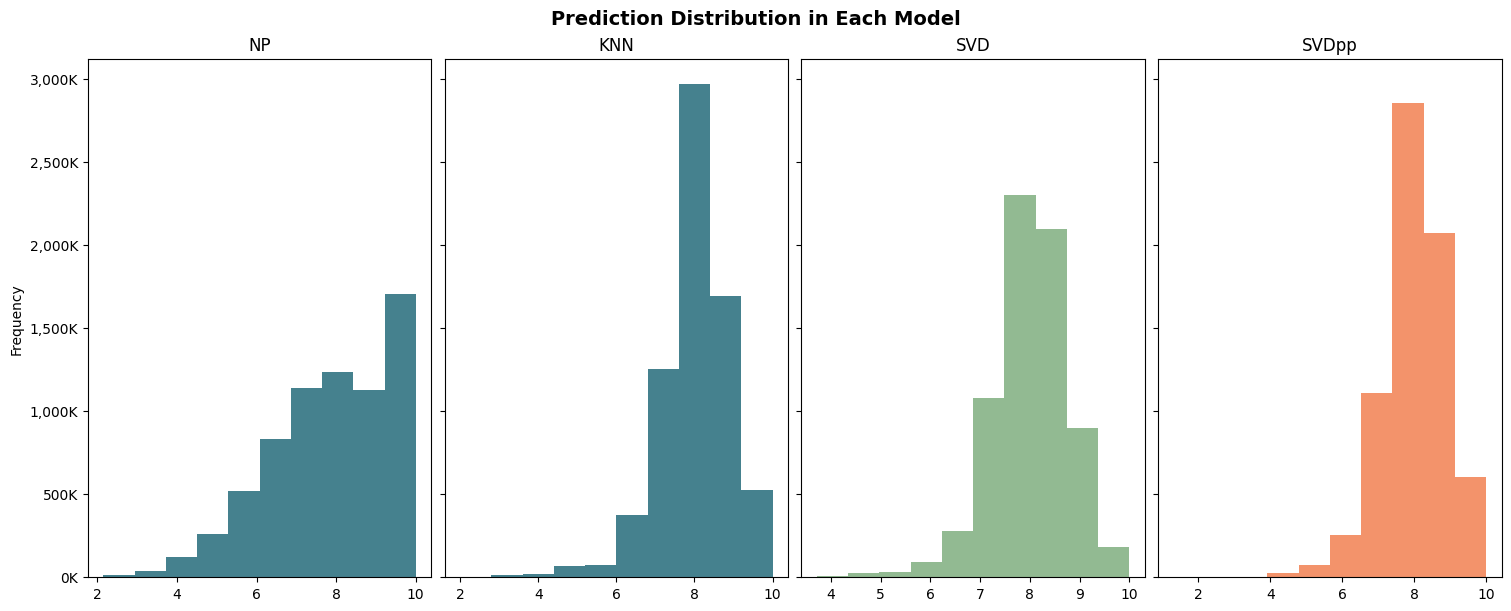

In [ ]:
# Mengembalikan nilai prediksi ke skala asli
DataFrame_np['est'] = DataFrame_np['est']
DataFrame_knn['est'] = DataFrame_knn['est']
DataFrame_svd['est'] = DataFrame_svd['est']
DataFrame_svdpp['est'] = DataFrame_svdpp['est']

# Membuat plot histogram untuk distribusi prediksi
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 6), sharey=True, constrained_layout=True)
DataFrame_np['est'].plot(kind='hist', title='NP', ax=ax1, color='#45818E')
DataFrame_knn['est'].plot(kind='hist', title='KNN', ax=ax2, color='#45818E')
DataFrame_svd['est'].plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
DataFrame_svdpp['est'].plot(kind='hist', title='SVDpp', ax=ax4, color='#F3936B')

# Menyesuaikan nilai pada sumbu y
# current_values = plt.gca().get_yticks()
# plt.gca().set_yticklabels(['{:,.0f}K'.format(x) for x in current_values])
# plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=14)
# plt.show()

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}K'.format(x) for x in current_values])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=14)
plt.show()

In [ ]:
# # ngeprediksi setiap count rating yang diberikan
# DataFrame_np['est'] = DataFrame_np['est'] * 2
# DataFrame_knn['est'] = DataFrame_knn['est'] * 2
# DataFrame_svd['est'] = DataFrame_svd['est'] * 2
# DataFrame_svdpp['est'] = DataFrame_svdpp['est'] * 2

# #membuat plot
# figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(15, 6), sharey=True, constrained_layout=True)
# DataFrame_np['est'].plot(kind='hist', title='NP', ax=ax1, color='#45818E')
# DataFrame_knn['est'].plot(kind='hist', title='KNN', ax=ax2, color='#45818E')
# DataFrame_svd['est'].plot(kind='hist', title='SVD', ax=ax3, color='#92BA92')
# DataFrame_svdpp['est'].plot(kind='hist', title='SVDpp', ax=ax4, color='#F3936B')

# current_values = plt.gca().get_yticks() / 1000
# plt.gca().set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in current_values])
# plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=14)
# plt.show()

Comparison of rating estimation in each model

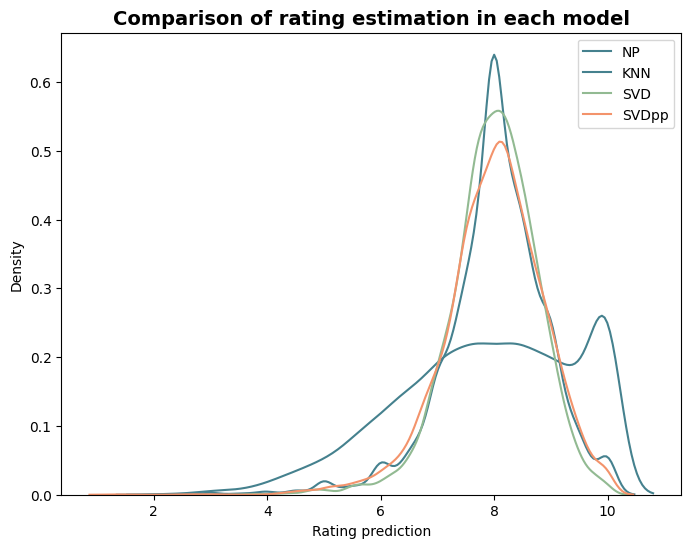

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(DataFrame_np['est'], shade=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(DataFrame_knn['est'], shade=False, color='#45818E', label = 'KNN', ax=ax)
sns.kdeplot(DataFrame_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(DataFrame_svdpp['est'], shade=False, color='#F3936B', label = 'SVDpp', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

Hyperparameter Tuning On Best Model

In [ ]:
#Load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(Ratings, reader)

In [ ]:
# prepare train data
data.raw_ratings = train_ratings

In [ ]:
%%time

grid = {'n_epochs': [20, 30],
        'lr_all': [.005, .001],
        'reg_all': [0.02, 0.04]}

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=2, n_jobs=1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

3.449518402568218
{'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.02}
CPU times: user 4.73 s, sys: 60.7 ms, total: 4.79 s
Wall time: 4.82 s


In [ ]:
#select best algorithm
svdtuned = gs.best_estimator['rmse']

In [ ]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

CPU times: user 493 ms, sys: 0 ns, total: 493 ms
Wall time: 527 ms


In [ ]:
%%time

# Compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

Train RMSE:
RMSE: 3.4495
CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 191 ms


In [ ]:
%%time

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

Test RMSE:
RMSE: 3.4623
CPU times: user 77.3 ms, sys: 0 ns, total: 77.3 ms
Wall time: 84.1 ms


In [ ]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

CPU times: user 675 ms, sys: 4.3 ms, total: 679 ms
Wall time: 722 ms


In [ ]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return Books[Books.ISBN.isin(book_ids)][['ISBN', 'title', 'author', 'average_rating', 'count_ratings']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation(276729, 5)

,ISBN,title,author,average_rating,count_ratings
0,0060283130,The Reptile Room (A Series of Unfortunate Even...,Lemony Snicket,8.00,49
1,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,8.34,3364
2,0060502258,The Divine Secrets of the Ya-Ya Sisterhood: A ...,Rebecca Wells,7.81,3364
3,0060809833,Brave New World,Aldous Huxley,9.10,100
4,0060830956,Brave New World,Aldous Huxley,8.75,64


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_tuning', svdtuned_test_pred, svdtuned)

In [ ]:
# uncomment this code to load the dump file
svd_test_pred, svd = dump.load('./dump_svd')
svdtuned_test_pred, svdtuned = dump.load('./dump_tuning')

In [ ]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [ ]:
from surprise import accuracy

# Hitung RMSE untuk model SVD dasar
print("RMSE for base SVD model:")
accuracy.rmse(svd_test_pred)

# Hitung RMSE untuk model SVD yang di-tuning
print("RMSE for tuned SVD model:")
accuracy.rmse(svdtuned_test_pred)


RMSE for base SVD model:
RMSE: 1.5652
RMSE for tuned SVD model:
RMSE: 3.4623


3.4622633529290874

In [ ]:
#mengali hasil setiap nilai tersebut
df_svd['est'] = df_svd['est'] * 2
df_svdtuned['est'] = df_svdtuned['est'] * 2

fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label='SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], shade=False, color='#DEBA9D', label='Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()

NameError: name 'df_svd' is not defined